In [2]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai

load_dotenv()

# --- Gemini Model Initialization ---
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.invoke("what is machine learning?")

AIMessage(content='Machine learning (ML) is a subfield of artificial intelligence (AI) that focuses on enabling computers to learn from data without being explicitly programmed. In simpler terms, it\'s about giving computers the ability to improve their performance on a specific task over time as they are exposed to more data.\n\nHere\'s a breakdown of the key concepts:\n\n*   **Learning from Data:** ML algorithms learn patterns, relationships, and insights from data. This data can be in various forms, such as numbers, text, images, or audio.\n*   **Algorithms:** Machine learning uses algorithms to analyze data and make predictions or decisions. These algorithms are designed to identify patterns and relationships within the data.\n*   **Without Explicit Programming:** Instead of being explicitly programmed with rules, ML models learn the rules from the data itself.  This is different from traditional programming where you tell the computer exactly what to do in every situation.\n*   **

In [5]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=1000)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_api_wrapper, description="query and summarize arxiv papers")

arxiv_tool.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [6]:
wiki_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)

wiki.invoke("tell me about Whitehouse")

'Page: Sheldon Whitehouse\nSummary: Sheldon Whitehouse (born October 20, 1955) is an American lawyer and politician serving since 2007 as the junior United States senator from Rhode Island. A member of the Democratic Party, he served from 1993 to 1998 as the United States Attorney for the District of Rhode Island and from 1999 to 2003 as the 71st attorney general of Rhode Island. In 2006, he was elected to the Senate, defeating Republican incumbent Lincoln Chafee. He was reelected in 2012, 2018, and 2024.\nA political progressive and climate hawk, Whitehouse became chair of the United States Senate Committee on the Budget in 2023. He has given hundreds of Senate floor speeches about climate change and asserted that politically conservative "dark money" groups are conducting a campaign to take control of the U.S. government, specifically the Supreme Court of the United States, to prevent climate action, among other reasons.\n\n\n\nPage: The Fast Show\nSummary: The Fast Show, also known 

In [8]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("How is Bangalore weather now?")

"The temperature in Bangalore today in the early morning is 23 ° C.. If you take into account factors such as wind, humidity and other weather conditions, the temperatures can feel like 25 ° C.. The chance of rain in Bangalore in the morning is 0%, and the wind will blow at 8 km/h. The Bangalore weather update by IMD has forecast gusty winds reaching speeds of 30-40m/h, cloudy skies, and possible light showers in Bengaluru today. Bengaluru Live Weather Today: Recent reports from weather stations near Bengaluru. Weather Station Temp. Weather Wind Gusts. Cloud. Visibility. Cloud / Visibility. Sampige Road wx. 3 km NW. 909 m alt. 18 minutes ago. 29.0 ° C-Bangalore Airport. 6 km ESE. 897 m alt. 1 hour ago. Today's and tonight's professional weather forecast for Bangalore (South). Precipitation radar, HD satellite images, and current weather warnings, hourly temperature, chance of rain, and sunshine hours. ... Premium users of the meteoblue weather app now benefit from a 14-day forecast and

In [9]:
tools = [arxiv_tool,wiki,search]

In [11]:
llm_tools = llm.bind_tools(tools=tools)

In [13]:
llm_tools.invoke("what is recent AI news?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "recent AI news"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--0148c4d1-2773-4a8a-9965-84949b84596c-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'recent AI news'}, 'id': '972a2482-4405-435d-b605-90a82545a1be', 'type': 'tool_call'}], usage_metadata={'input_tokens': 110, 'output_tokens': 9, 'total_tokens': 119, 'input_token_details': {'cache_read': 0}})

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [15]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


In [18]:
def tool_calling_llm(state: State):
    return {"messages": [llm_tools.invoke(state["messages"])]}

In [23]:
builder = StateGraph(State)

builder.add_node("llm_node",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_node")
builder.add_conditional_edges(
    "llm_node",
    tools_condition
)
builder.add_edge("tools","llm_node")

graph = builder.compile()


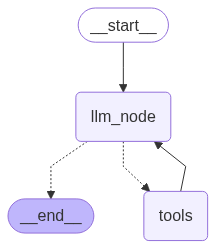

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
response  = graph.invoke({"messages": "what is  AI and provide research paper also"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is  AI and provide research paper also
================================== Ai Message ==================================
Tool Calls:
  wikipedia (487f0348-317f-49db-ae84-2ba653af5b40)
 Call ID: 487f0348-317f-49db-ae84-2ba653af5b40
  Args:
    query: Artificial Intelligence
  arxiv (b5edbe81-d080-41c4-952a-61e4e36c6c92)
 Call ID: b5edbe81-d080-41c4-952a-61e4e36c6c92
  Args:
    query: Artificial Intelligence
================================= Tool Message =================================
Name: wikipedia

Page: Artificial intelligence
Summary: Artificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment a